In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import random


In [2]:
# Download data
START_DATE = '2010-01-01'
END_DATE = '2020-12-31'
STOCKS = ['AAPL','TSLA', 'AMZN', 'GOOGL', 'MSFT', 'META','NVDA']

def download_data(tickers, start, end):
    data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end)
        df = df.dropna()
        data[ticker] = df
    return data

data = download_data(STOCKS, START_DATE, END_DATE)


# Add technical indicators
def add_technical_indicators(df):
    close = df['Close']
    
    # Ensure 'close' is a Series
    if isinstance(close, pd.DataFrame):
        close = close.squeeze()
    
    # Ensure 'close' is 1D
    if len(close.shape) > 1:
        close = close.flatten()
    
    # Compute indicators
    df['MA50'] = ta.trend.sma_indicator(close, window=50)
    df['MA200'] = ta.trend.sma_indicator(close, window=200)
    df['RSI'] = ta.momentum.RSIIndicator(close, window=14).rsi()
    df['MACD'] = ta.trend.MACD(close).macd()
    
    df = df.dropna()
    return df

for ticker in STOCKS:
    data[ticker] = add_technical_indicators(data[ticker])
    

TRAIN_TEST_SPLIT = 0.8
for ticker in STOCKS:
    data[ticker] = add_technical_indicators(data[ticker])

train_data = {}
test_data = {}
for ticker in STOCKS:
    df = data[ticker]
    split_idx = int(len(df) * TRAIN_TEST_SPLIT)
    train_data[ticker] = df[:split_idx]
    test_data[ticker] = df[split_idx:]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
class TradingEnv(gym.Env):
    def __init__(self, df, initial_balance=100000, window_size=60):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.window_size = window_size
        self.current_step = 0
        self.balance = initial_balance
        self.net_worth = initial_balance
        self.shares_held = 0
        self.max_steps = len(self.df) - window_size

        # Actions: Continuous value between -1 and 1
        # -1: Sell all shares
        # 0: Hold
        # 1: Buy maximum shares possible
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

        # Observation space
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(window_size, len(self.df.columns)),
            dtype=np.float32
        )
        
    
    def reset(self):
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.shares_held = 0
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        frame = self.df.iloc[self.current_step:self.current_step + self.window_size]
        obs = frame.values
        # Normalize observations
        obs = (obs - obs.mean()) / (obs.std() + 1e-8)
        return obs.astype(np.float32)
    
    def step(self, action):
        # Ensure action is a scalar within [-1, 1]
        action = np.clip(action, -1, 1)[0]

        # Get current price
        current_price = float(self.df.iloc[self.current_step + self.window_size - 1]['Close'])
        prev_net_worth = self.net_worth

        # Calculate the amount to trade
        # Positive action: Buy, Negative action: Sell
        amount = action * self.initial_balance  # Scale action to initial balance
        shares_to_trade = amount / current_price

        # Execute trade
        if action > 0:
            # Buy shares
            max_shares_can_buy = self.balance / current_price
            shares_bought = min(max_shares_can_buy, shares_to_trade)
            cost = shares_bought * current_price
            self.balance -= cost
            self.shares_held += shares_bought
            shares_traded = shares_bought
        elif action < 0:
            # Sell shares
            shares_sold = min(self.shares_held, -shares_to_trade)
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            shares_traded = -shares_sold
        else:
            shares_traded = 0  # Hold

        # Update net worth
        self.net_worth = self.balance + self.shares_held * current_price

        # Calculate reward
        reward = self.net_worth - prev_net_worth

        # Transaction cost (e.g., 0.1% per trade)
        transaction_cost = 0.001 * current_price * abs(shares_traded)
        reward -= transaction_cost

        # Normalize reward
        reward /= self.initial_balance

        # Move to next timestep
        self.current_step += 1
        done = self.current_step >= self.max_steps

        # Get next observation
        obs = self._next_observation()

        return obs, reward, done, {}
    
    

In [5]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()  # Output actions between -1 and 1

    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        action = self.tanh(self.fc3(x))
        return action

class Critic(nn.Module):
    def __init__(self, state_size, action_size, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)  # Concatenate state and action
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value


In [6]:
class DDPGAgent:
    def __init__(self, state_size, action_size, hidden_dim=64, actor_lr=1e-4, critic_lr=1e-3, gamma=0.99, tau=1e-3, device='cpu'):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.tau = tau  # For soft update
        self.device = torch.device(device)
        self.noise = OUNoise(action_dimension=self.action_size)


        # Actor Network
        self.actor = Actor(state_size, action_size, hidden_dim).to(self.device)
        self.target_actor = Actor(state_size, action_size, hidden_dim).to(self.device)
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)

        # Critic Network
        self.critic = Critic(state_size, action_size, hidden_dim).to(self.device)
        self.target_critic = Critic(state_size, action_size, hidden_dim).to(self.device)
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

        # Replay Buffer
        self.memory = deque(maxlen=100000)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        self.actor.eval()
        with torch.no_grad():
            action = self.actor(state)
        self.actor.train()
        action = action.cpu().data.numpy().flatten()
        noise = self.noise.sample()
        action += noise
        return np.clip(action, -1, 1)

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states = torch.FloatTensor([m[0] for m in minibatch]).to(self.device)
        actions = torch.FloatTensor([m[1] for m in minibatch]).to(self.device)
        rewards = torch.FloatTensor([m[2] for m in minibatch]).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor([m[3] for m in minibatch]).to(self.device)
        dones = torch.FloatTensor([float(m[4]) for m in minibatch]).unsqueeze(1).to(self.device)

        # Critic loss
        next_actions = self.target_actor(next_states)
        next_q_values = self.target_critic(next_states, next_actions)
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        q_values = self.critic(states, actions)
        critic_loss = nn.MSELoss()(q_values, target_q_values.detach())

        # Update Critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor loss
        actor_loss = -self.critic(states, self.actor(states)).mean()

        # Update Actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update target networks
        self.soft_update(self.actor, self.target_actor)
        self.soft_update(self.critic, self.target_critic)

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)


In [7]:
class OUNoise:
    def __init__(self, action_dimension, mu=0.0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def sample(self):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(len(self.state))
        self.state += dx
        return self.state


In [8]:
def train_ddpg_agent(env, agent, num_episodes=100, batch_size=64, max_steps=1000):
    rewards_history = []
    for episode in range(num_episodes):
        state = env.reset()
        state_flat = state.flatten()
        agent.noise.reset()
        episode_reward = 0
        for step in range(max_steps):
            # Select action
            action = agent.select_action(state_flat)
            next_state, reward, done, _ = env.step(action)
            next_state_flat = next_state.flatten()
            # Store experience
            agent.remember(state_flat, action, reward, next_state_flat, done)
            # Replay and train
            agent.replay(batch_size)
            state_flat = next_state_flat
            episode_reward += reward
            if done:
                break
        rewards_history.append(episode_reward)
        print(f"Episode {episode+1}/{num_episodes}, Total Reward: {episode_reward:.2f}")
    return rewards_history


In [9]:
def test_ddpg_agent(env, agent):
    state = env.reset()
    done = False
    total_reward = 0
    net_worths = []
    actions = []
    prices = []
    steps = []
    balances = []
    shares_helds = []

    while not done:
        state_flat = state.flatten()
        # Select action
        state_tensor = torch.FloatTensor(state_flat).unsqueeze(0).to(agent.device)
        with torch.no_grad():
            action = agent.actor(state_tensor).cpu().data.numpy().flatten()
        action = np.clip(action, -1, 1)
        next_state, reward, done, _ = env.step(action)
        next_state_flat = next_state.flatten()

        # Record data
        net_worths.append(env.net_worth)
        actions.append(action[0])
        current_price = float(env.df.iloc[env.current_step + env.window_size - 1]['Close'])
        prices.append(current_price)
        steps.append(env.current_step)
        balances.append(env.balance)
        shares_helds.append(env.shares_held)

        state = next_state
        total_reward += reward

    print(f"Test completed. Total Reward: {total_reward}")
    return net_worths, actions, prices, steps, balances, shares_helds


In [10]:
def plot_test_performance_ddpg(net_worths, actions, prices, steps):
    # Plot Net Worth Over Time
    plt.figure(figsize=(14,7))
    plt.subplot(2,1,1)
    plt.plot(steps, net_worths, label='Agent Net Worth')
    plt.xlabel('Time Steps')
    plt.ylabel('Net Worth ($)')
    plt.title('Agent Net Worth Over Time')
    plt.legend()

    # Plot Actions Over Time
    plt.subplot(2,1,2)
    plt.plot(steps, prices, label='Stock Price')
    # Actions as color map
    sc = plt.scatter(steps, prices, c=actions, cmap='coolwarm', label='Actions')
    plt.colorbar(sc, label='Action Value (-1 to 1)')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price ($)')
    plt.title('Agent Actions Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
def plot_cumulative_returns(net_worths, env):
    initial_balance = env.initial_balance
    agent_returns = np.array(net_worths) / initial_balance - 1
    
    # Buy-and-hold returns
    initial_price = float(env.df.iloc[env.window_size - 1]['Close'])
    final_prices = env.df['Close'].values[env.window_size - 1:]
    buy_and_hold_returns = final_prices / initial_price - 1
    
    # Ensure the lengths match
    min_length = min(len(agent_returns), len(buy_and_hold_returns))
    agent_returns = agent_returns[:min_length]
    buy_and_hold_returns = buy_and_hold_returns[:min_length]
    
    plt.figure(figsize=(12,6))
    plt.plot(agent_returns, label='Agent Strategy')
    plt.plot(buy_and_hold_returns, label='Buy and Hold Strategy')
    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative Returns')
    plt.title('Cumulative Returns Comparison')
    plt.legend()
    plt.show()


def plot_portfolio_components(net_worths, balances, equity_values):
    plt.figure(figsize=(12,6))
    plt.plot(balances, label='Cash Balance')
    plt.plot(equity_values, label='Equity Value')
    plt.plot(net_worths, label='Total Net Worth')
    plt.xlabel('Time Steps')
    plt.ylabel('Value ($)')
    plt.title('Portfolio Components Over Time')
    plt.legend()
    plt.show()


def plot_test_performance(net_worths, actions, prices, steps):
    # Plot Net Worth Over Time
    plt.figure(figsize=(14,7))
    plt.subplot(2,1,1)
    plt.plot(steps, net_worths, label='Agent Net Worth')
    plt.xlabel('Time Steps')
    plt.ylabel('Net Worth ($)')
    plt.title('Agent Net Worth Over Time')
    plt.legend()
    
    # Plot Actions Over Time
    plt.subplot(2,1,2)
    plt.plot(steps, prices, label='Stock Price')
    
    # Define action categories based on the new action space
    buy_actions = [1, 2, 3]
    sell_actions = [4, 5, 6]
    hold_actions = [0]
    
    # Map actions to percentages for labeling
    action_labels = {
        1: 'Buy 10%',
        2: 'Buy 50%',
        3: 'Buy 100%',
        4: 'Sell 10%',
        5: 'Sell 50%',
        6: 'Sell 100%',
    }
    
    # Plot buy actions
    for action in buy_actions:
        action_steps = [s for s, a in zip(steps, actions) if a == action]
        action_prices = [prices[i - steps[0]] for i in action_steps]
        plt.scatter(action_steps, action_prices, marker='^', label=action_labels[action])
    
    # Plot sell actions
    for action in sell_actions:
        action_steps = [s for s, a in zip(steps, actions) if a == action]
        action_prices = [prices[i - steps[0]] for i in action_steps]
        plt.scatter(action_steps, action_prices, marker='v', label=action_labels[action])
    
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price ($)')
    plt.title('Agent Actions Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()


def compute_buy_and_hold(env):
    initial_balance = env.initial_balance
    initial_price = float(env.df.iloc[env.window_size - 1]['Close'])
    final_price = float(env.df.iloc[-1]['Close'])
    shares = initial_balance // initial_price
    remaining_balance = initial_balance - shares * initial_price
    final_net_worth = remaining_balance + shares * final_price
    return final_net_worth


def compute_performance_metrics(net_worths):
    net_worths = np.array(net_worths)
    returns = np.diff(net_worths) / net_worths[:-1]
    total_return = (net_worths[-1] - net_worths[0]) / net_worths[0]
    annualized_return = total_return * (252 / len(net_worths))  # Assuming daily data

    # Sharpe Ratio
    risk_free_rate = 0.0  # Assuming zero risk-free rate
    if np.std(returns) != 0:
        sharpe_ratio = (np.mean(returns) - risk_free_rate) / np.std(returns) * np.sqrt(252)
    else:
        sharpe_ratio = 0.0  # Avoid division by zero

    # Maximum Drawdown
    cumulative_returns = net_worths / net_worths[0]
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = (running_max - cumulative_returns) / running_max
    max_drawdown = np.max(drawdowns)

    print(f"Total Return: {total_return * 100:.2f}%")
    print(f"Annualized Return: {annualized_return * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")




Training DDPG agent for AAPL


C:\Users\ggwzz\AppData\Local\Temp\ipykernel_29728\2355944492.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(self.df.iloc[self.current_step + self.window_size - 1]['Close'])
C:\Users\ggwzz\AppData\Local\Temp\ipykernel_29728\4122567769.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.FloatTensor([m[0] for m in minibatch]).to(self.device)


Episode 1/1000, Total Reward: 1.04
Episode 2/1000, Total Reward: 2.03
Episode 3/1000, Total Reward: 1.97
Episode 4/1000, Total Reward: 2.00
Episode 5/1000, Total Reward: 2.04
Episode 6/1000, Total Reward: 1.86
Episode 7/1000, Total Reward: 0.90
Episode 8/1000, Total Reward: 2.94
Episode 9/1000, Total Reward: 1.87
Episode 10/1000, Total Reward: 2.57
Episode 11/1000, Total Reward: 3.07
Episode 12/1000, Total Reward: 2.77
Episode 13/1000, Total Reward: 1.77
Episode 14/1000, Total Reward: 2.53
Episode 15/1000, Total Reward: 3.07
Episode 16/1000, Total Reward: 3.52
Episode 17/1000, Total Reward: 3.29
Episode 18/1000, Total Reward: 2.72
Episode 19/1000, Total Reward: 3.09
Episode 20/1000, Total Reward: 4.17
Episode 21/1000, Total Reward: 4.73
Episode 22/1000, Total Reward: 2.73
Episode 23/1000, Total Reward: 3.80
Episode 24/1000, Total Reward: 3.68
Episode 25/1000, Total Reward: 2.39
Episode 26/1000, Total Reward: 2.90
Episode 27/1000, Total Reward: 2.85
Episode 28/1000, Total Reward: 2.16
E

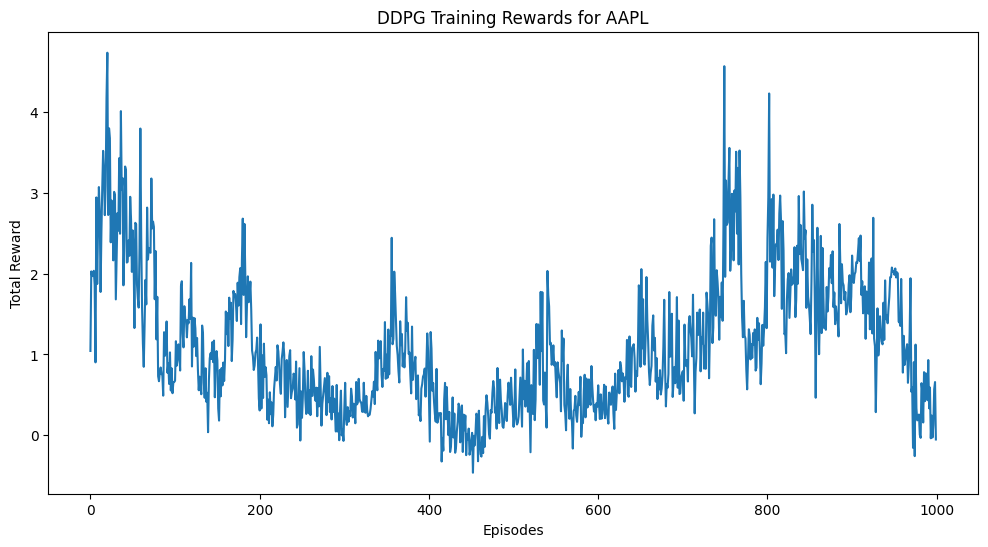


Testing DDPG agent for AAPL


C:\Users\ggwzz\AppData\Local\Temp\ipykernel_29728\751633420.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(env.df.iloc[env.current_step + env.window_size - 1]['Close'])


Test completed. Total Reward: 1.3882317744336694


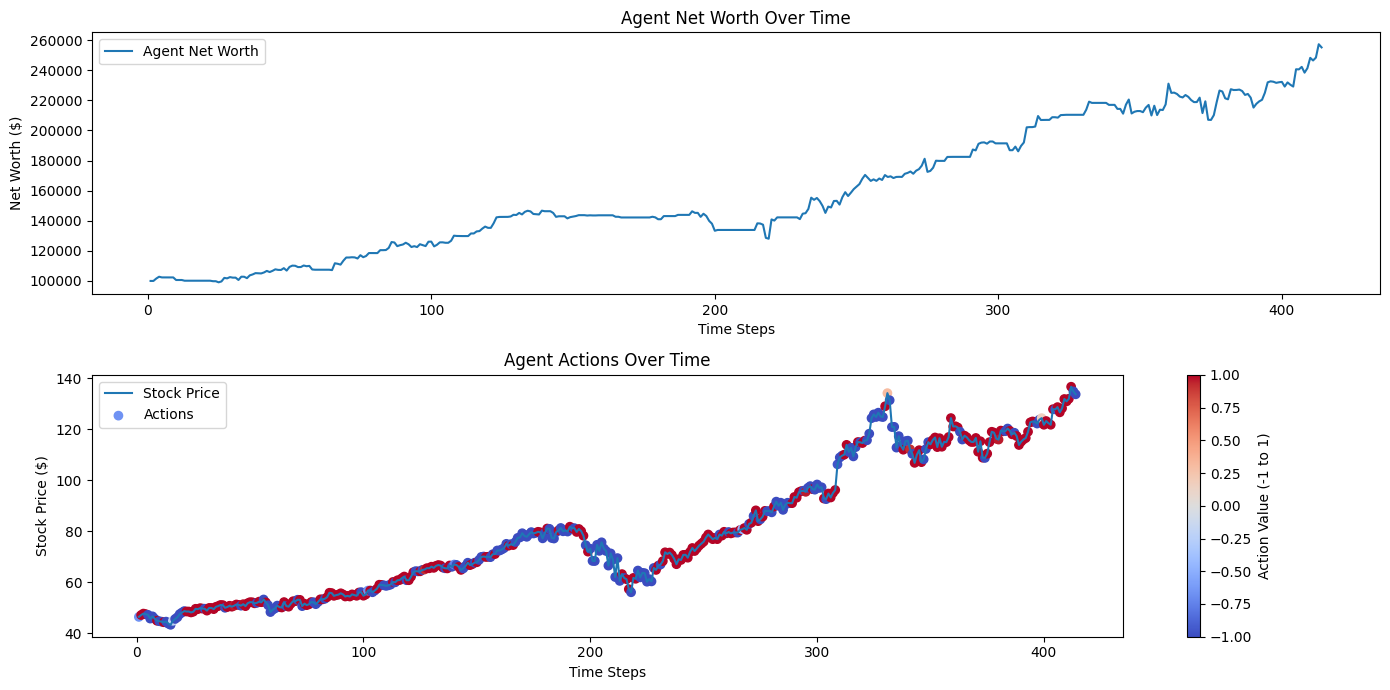

Total Return: 155.20%
Annualized Return: 94.47%
Sharpe Ratio: 2.58
Maximum Drawdown: 12.72%


C:\Users\ggwzz\AppData\Local\Temp\ipykernel_29728\3572311593.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_price = float(env.df.iloc[env.window_size - 1]['Close'])


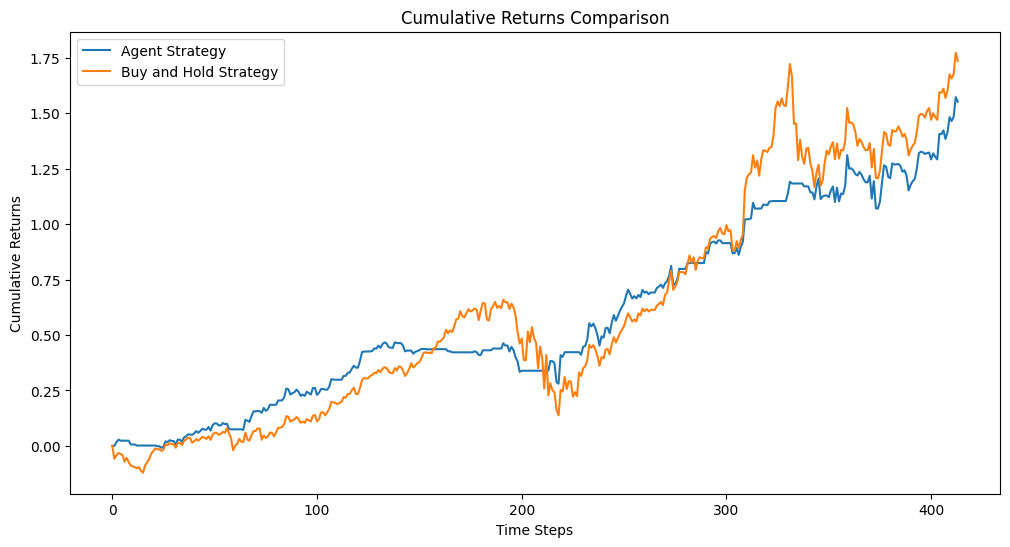

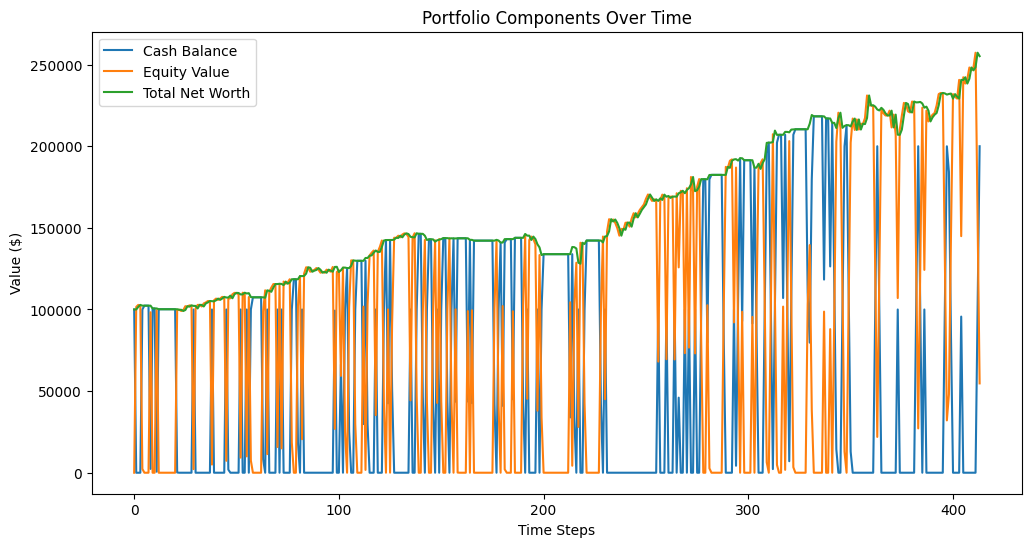


Training DDPG agent for TSLA
Episode 1/1000, Total Reward: 9.82
Episode 2/1000, Total Reward: 7.06
Episode 3/1000, Total Reward: 7.07
Episode 4/1000, Total Reward: 7.10
Episode 5/1000, Total Reward: 7.18
Episode 6/1000, Total Reward: 7.15
Episode 7/1000, Total Reward: 5.56
Episode 8/1000, Total Reward: 4.23
Episode 9/1000, Total Reward: 13.97
Episode 10/1000, Total Reward: 10.83
Episode 11/1000, Total Reward: 11.99
Episode 12/1000, Total Reward: 12.76
Episode 13/1000, Total Reward: 10.63
Episode 14/1000, Total Reward: 8.42
Episode 15/1000, Total Reward: 13.47
Episode 16/1000, Total Reward: 9.70
Episode 17/1000, Total Reward: 12.50
Episode 18/1000, Total Reward: 10.76
Episode 19/1000, Total Reward: 11.95
Episode 20/1000, Total Reward: 11.59
Episode 21/1000, Total Reward: 11.04
Episode 22/1000, Total Reward: 12.41
Episode 23/1000, Total Reward: 8.88
Episode 24/1000, Total Reward: 10.45
Episode 25/1000, Total Reward: 11.61
Episode 26/1000, Total Reward: 13.37
Episode 27/1000, Total Rewar

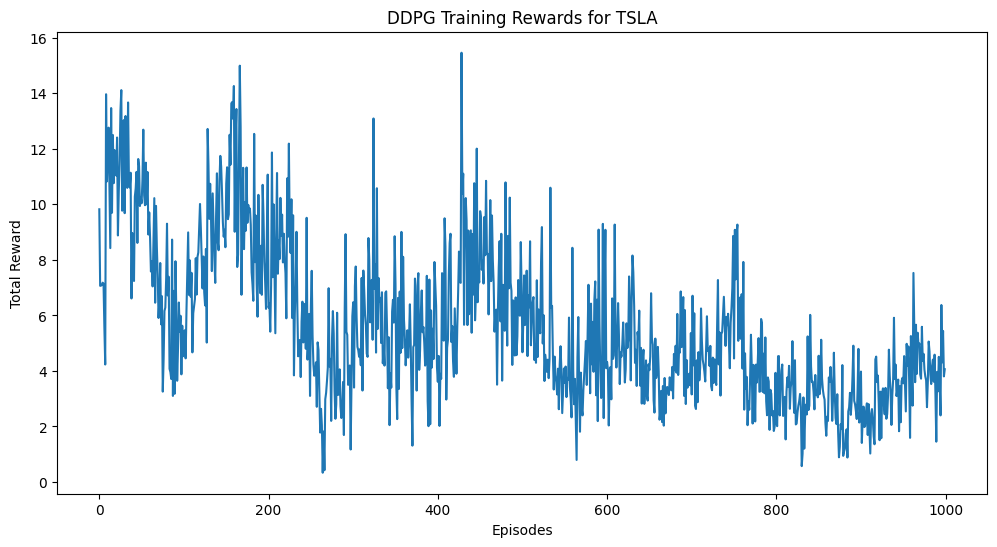


Testing DDPG agent for TSLA
Test completed. Total Reward: 3.061212853920417


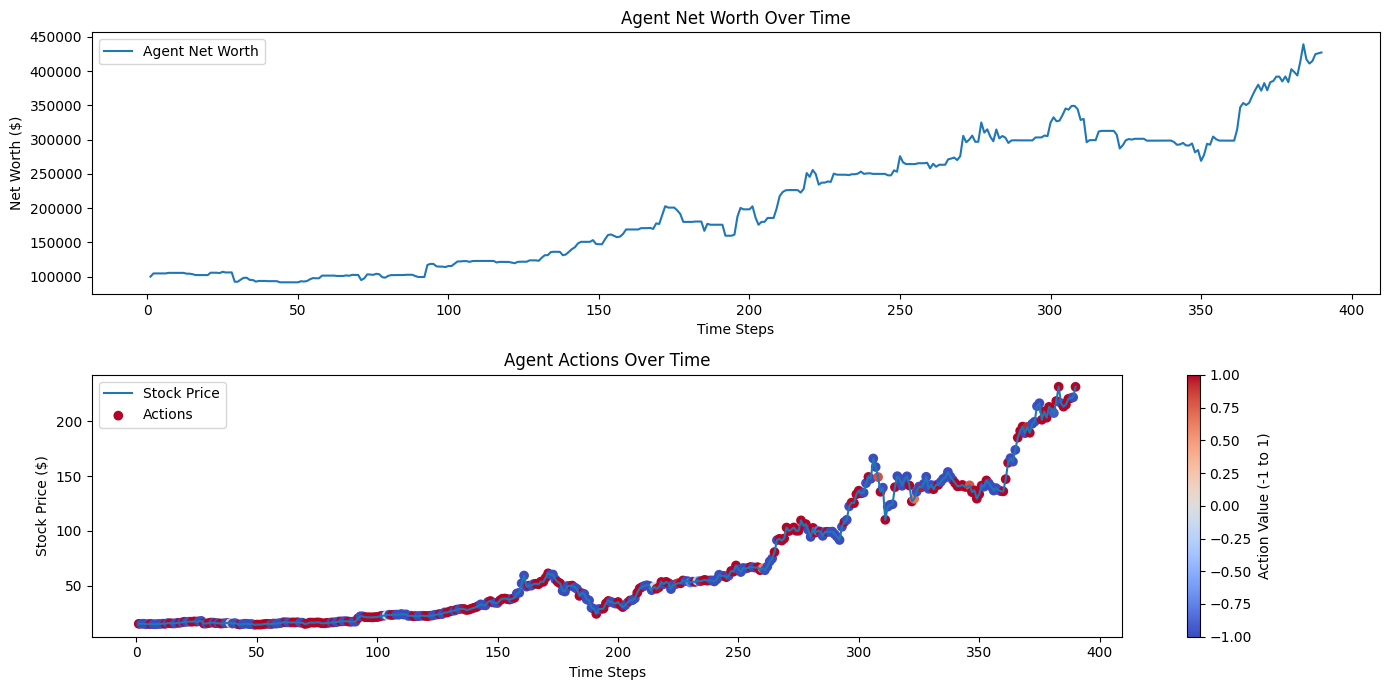

Total Return: 327.09%
Annualized Return: 211.35%
Sharpe Ratio: 2.30
Maximum Drawdown: 22.97%


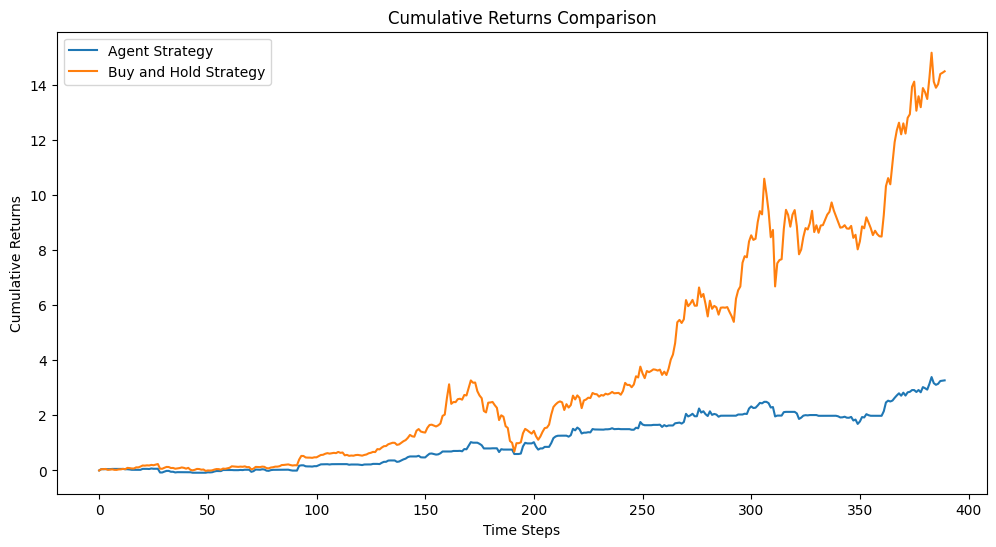

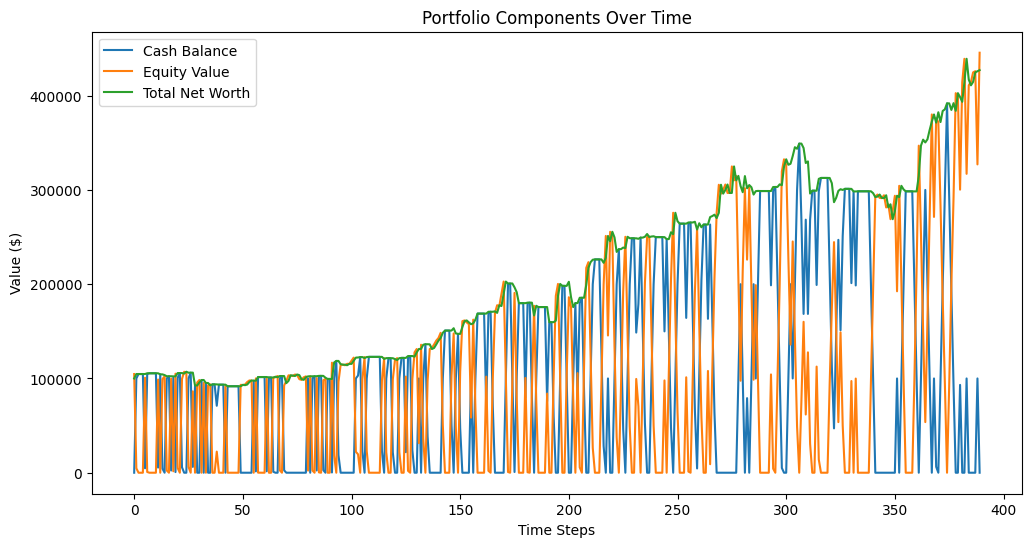


Training DDPG agent for AMZN
Episode 1/1000, Total Reward: 1.98
Episode 2/1000, Total Reward: 6.21
Episode 3/1000, Total Reward: 6.31
Episode 4/1000, Total Reward: 6.32
Episode 5/1000, Total Reward: 6.21
Episode 6/1000, Total Reward: 6.18
Episode 7/1000, Total Reward: 6.30
Episode 8/1000, Total Reward: 6.22
Episode 9/1000, Total Reward: 5.25
Episode 10/1000, Total Reward: 3.40
Episode 11/1000, Total Reward: 5.42
Episode 12/1000, Total Reward: 4.67
Episode 13/1000, Total Reward: 4.07
Episode 14/1000, Total Reward: 1.60
Episode 15/1000, Total Reward: 1.25
Episode 16/1000, Total Reward: 1.21
Episode 17/1000, Total Reward: 2.86
Episode 18/1000, Total Reward: 2.14
Episode 19/1000, Total Reward: 3.06
Episode 20/1000, Total Reward: 2.12
Episode 21/1000, Total Reward: 2.05
Episode 22/1000, Total Reward: 2.11
Episode 23/1000, Total Reward: 2.32
Episode 24/1000, Total Reward: 2.37
Episode 25/1000, Total Reward: 3.34
Episode 26/1000, Total Reward: 3.92
Episode 27/1000, Total Reward: 4.24
Episode

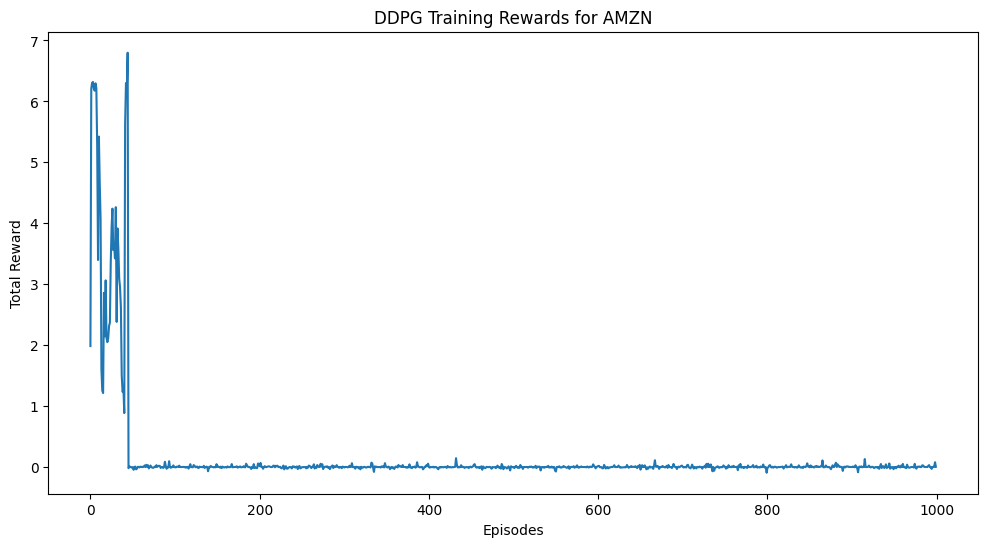


Testing DDPG agent for AMZN
Test completed. Total Reward: 0.0


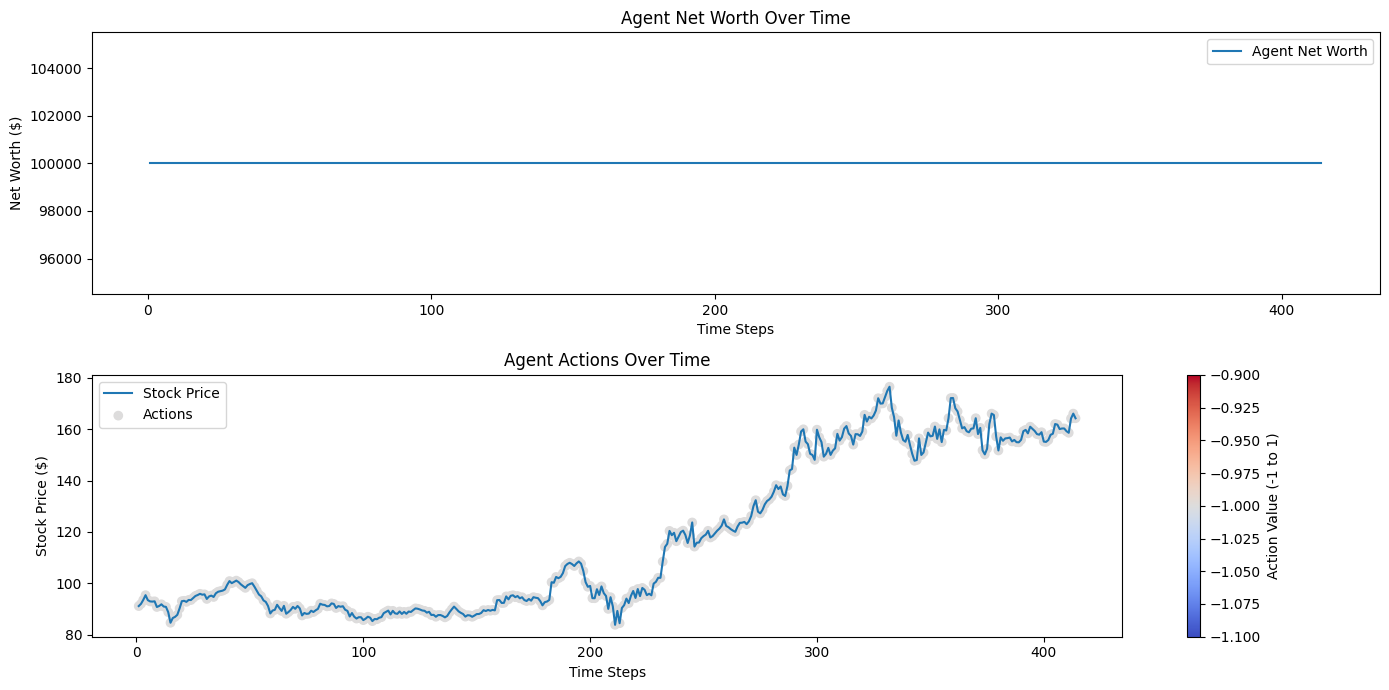

Total Return: 0.00%
Annualized Return: 0.00%
Sharpe Ratio: 0.00
Maximum Drawdown: 0.00%


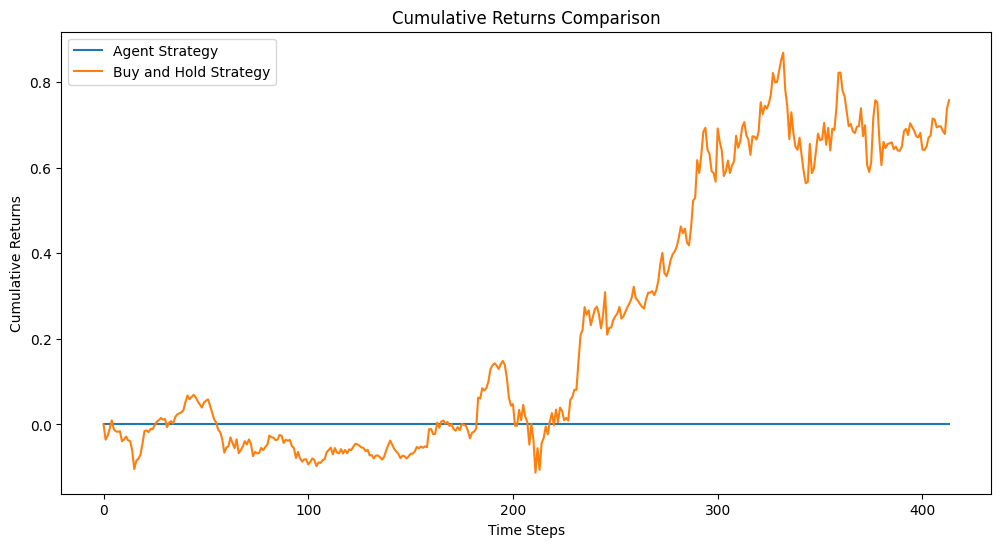

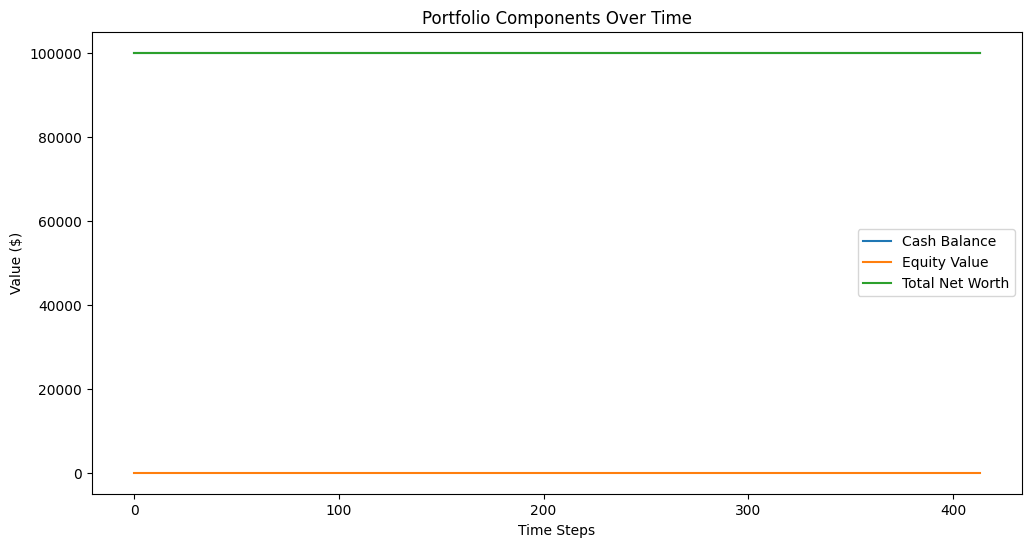


Training DDPG agent for GOOGL
Episode 1/1000, Total Reward: 2.85
Episode 2/1000, Total Reward: 2.78
Episode 3/1000, Total Reward: 2.87
Episode 4/1000, Total Reward: 2.84
Episode 5/1000, Total Reward: 2.68
Episode 6/1000, Total Reward: 0.00
Episode 7/1000, Total Reward: -0.01
Episode 8/1000, Total Reward: 0.01
Episode 9/1000, Total Reward: -0.00
Episode 10/1000, Total Reward: 0.02
Episode 11/1000, Total Reward: 0.01
Episode 12/1000, Total Reward: 0.00
Episode 13/1000, Total Reward: -0.19
Episode 14/1000, Total Reward: 0.32
Episode 15/1000, Total Reward: 0.51
Episode 16/1000, Total Reward: 1.78
Episode 17/1000, Total Reward: 1.39
Episode 18/1000, Total Reward: 1.22
Episode 19/1000, Total Reward: 1.09
Episode 20/1000, Total Reward: 2.18
Episode 21/1000, Total Reward: 1.35
Episode 22/1000, Total Reward: 3.13
Episode 23/1000, Total Reward: 2.16
Episode 24/1000, Total Reward: 2.20
Episode 25/1000, Total Reward: 2.86
Episode 26/1000, Total Reward: 1.85
Episode 27/1000, Total Reward: 3.21
Epi

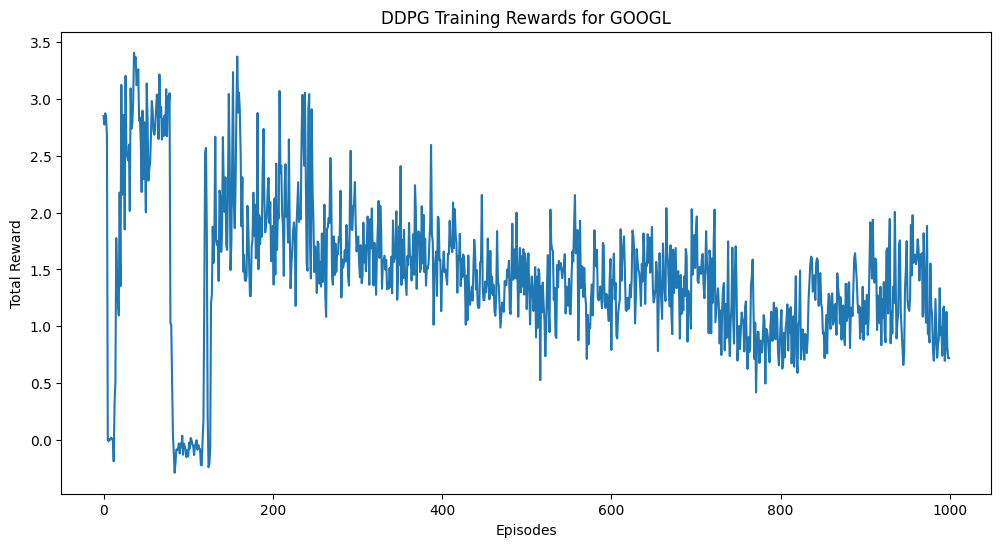


Testing DDPG agent for GOOGL
Test completed. Total Reward: 0.032359664548164295


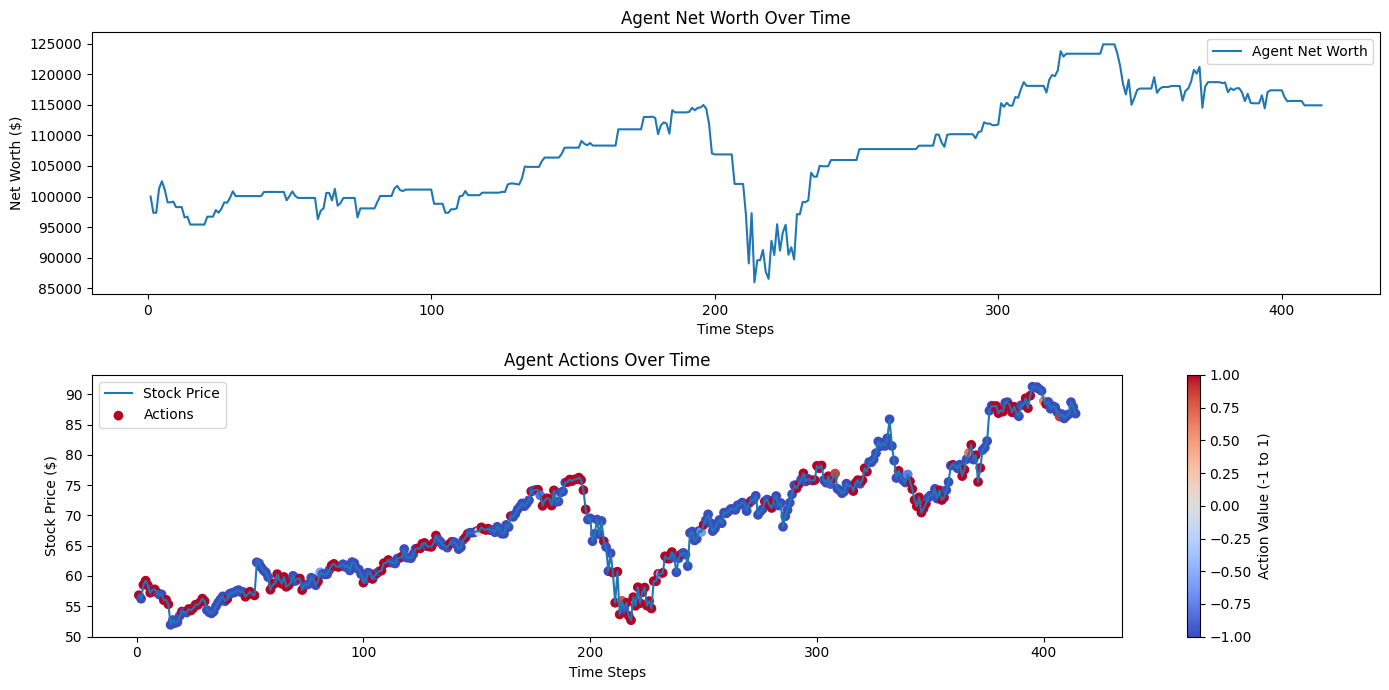

Total Return: 14.92%
Annualized Return: 9.08%
Sharpe Ratio: 0.47
Maximum Drawdown: 25.22%


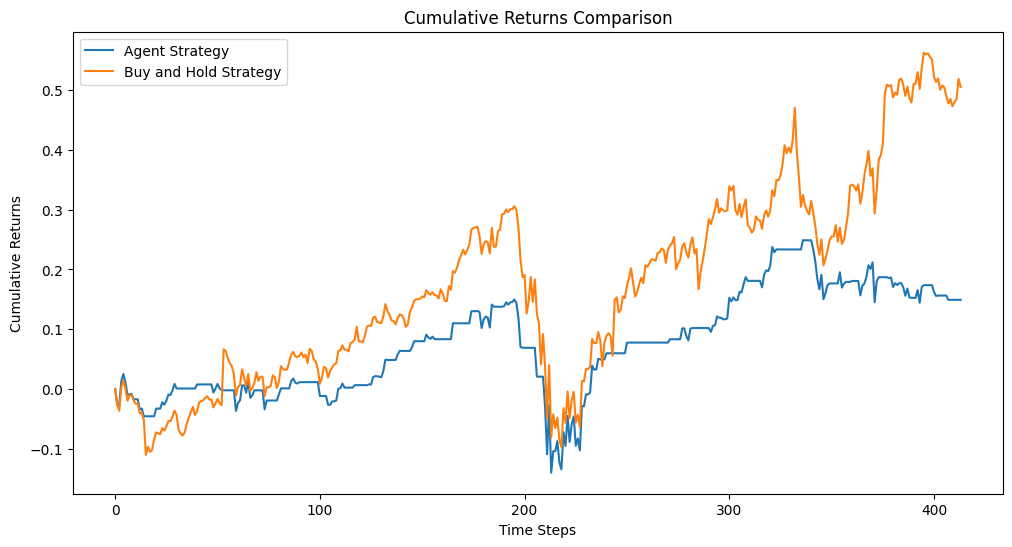

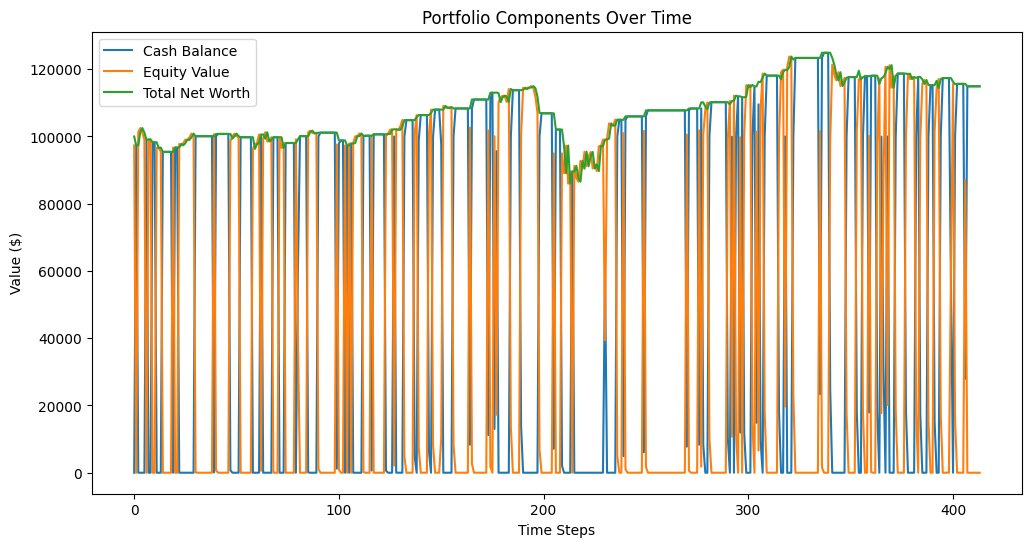


Training DDPG agent for MSFT
Episode 1/1000, Total Reward: 2.57
Episode 2/1000, Total Reward: 2.96
Episode 3/1000, Total Reward: 2.98
Episode 4/1000, Total Reward: 2.97
Episode 5/1000, Total Reward: 3.10
Episode 6/1000, Total Reward: 2.88
Episode 7/1000, Total Reward: 2.99
Episode 8/1000, Total Reward: 2.98
Episode 9/1000, Total Reward: 3.00
Episode 10/1000, Total Reward: 2.99
Episode 11/1000, Total Reward: 2.99
Episode 12/1000, Total Reward: 1.42
Episode 13/1000, Total Reward: 0.15
Episode 14/1000, Total Reward: 0.33
Episode 15/1000, Total Reward: 0.20
Episode 16/1000, Total Reward: 0.27
Episode 17/1000, Total Reward: 0.24
Episode 18/1000, Total Reward: 0.20
Episode 19/1000, Total Reward: 0.29
Episode 20/1000, Total Reward: 0.49
Episode 21/1000, Total Reward: 0.47
Episode 22/1000, Total Reward: 0.44
Episode 23/1000, Total Reward: 0.76
Episode 24/1000, Total Reward: 0.28
Episode 25/1000, Total Reward: 0.28
Episode 26/1000, Total Reward: 0.32
Episode 27/1000, Total Reward: 0.36
Episode

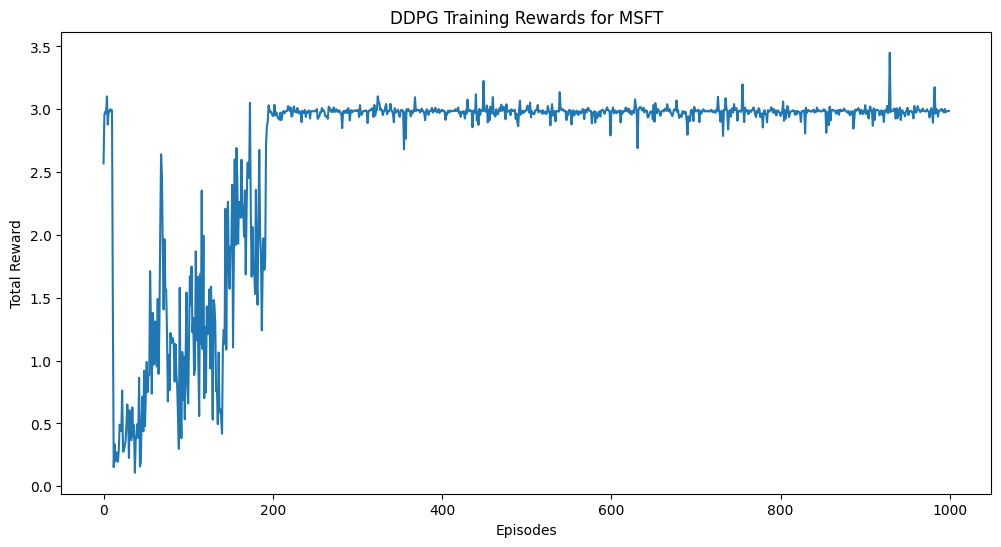


Testing DDPG agent for MSFT
Test completed. Total Reward: 0.7621558148284164


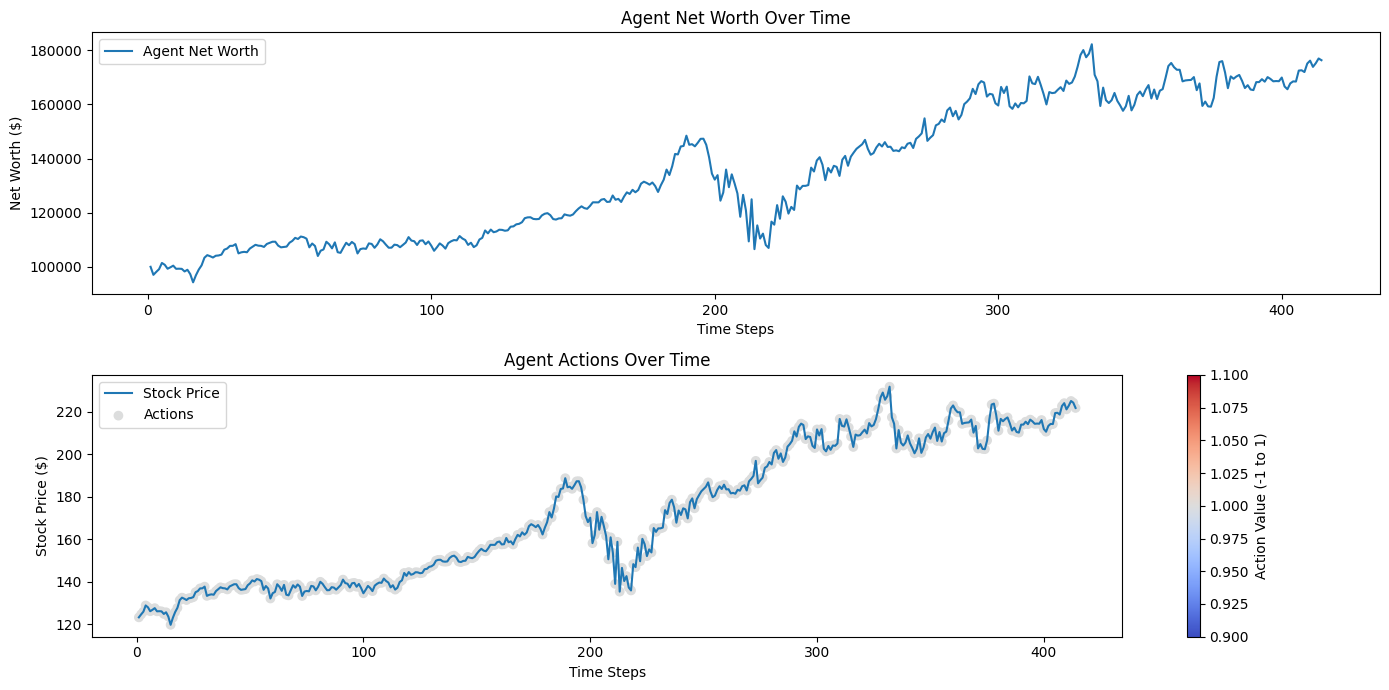

Total Return: 76.32%
Annualized Return: 46.45%
Sharpe Ratio: 1.14
Maximum Drawdown: 28.24%


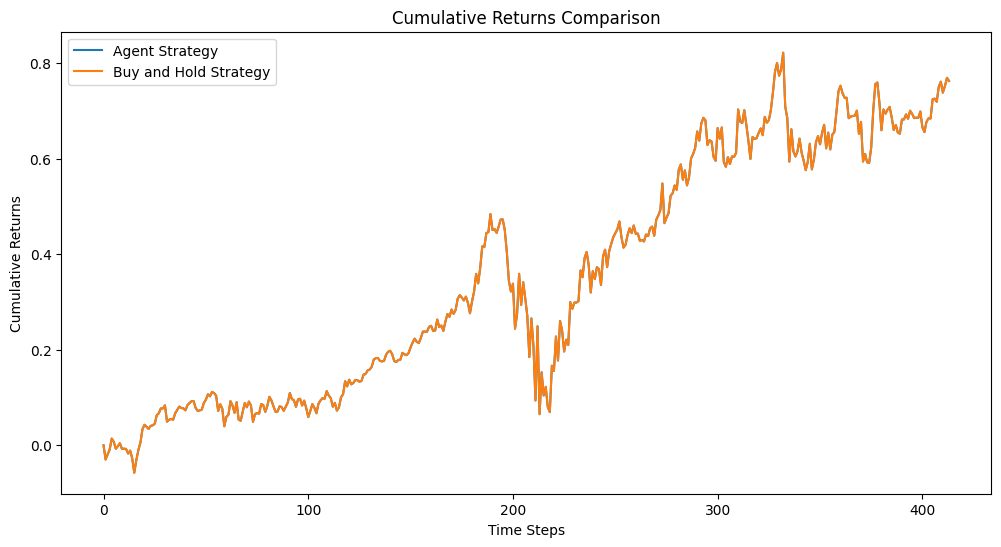

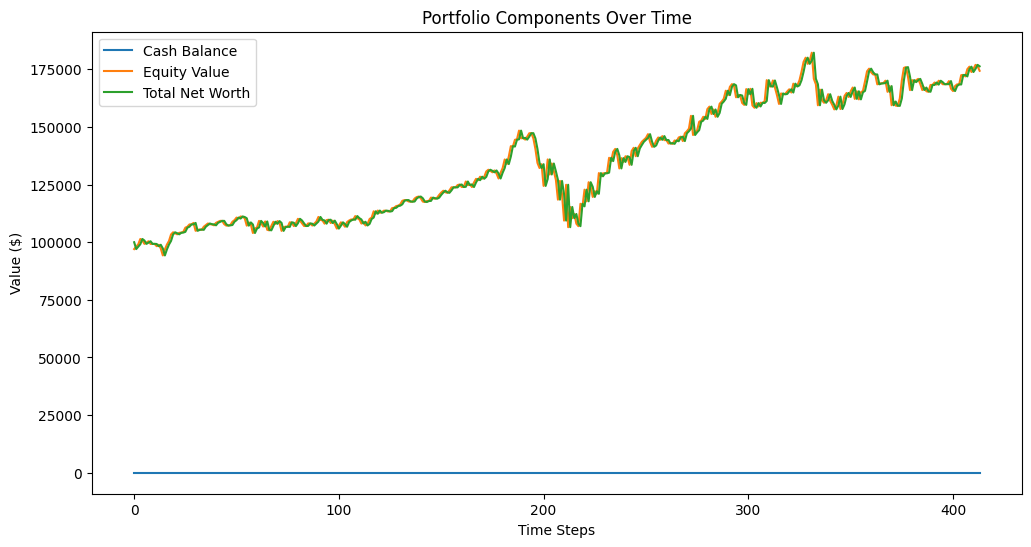


Training DDPG agent for META
Episode 1/1000, Total Reward: -0.06
Episode 2/1000, Total Reward: 0.45
Episode 3/1000, Total Reward: 0.73
Episode 4/1000, Total Reward: 1.91
Episode 5/1000, Total Reward: 1.55
Episode 6/1000, Total Reward: 2.24
Episode 7/1000, Total Reward: 1.93
Episode 8/1000, Total Reward: 2.41
Episode 9/1000, Total Reward: 2.35
Episode 10/1000, Total Reward: 2.07
Episode 11/1000, Total Reward: 0.13
Episode 12/1000, Total Reward: 1.41
Episode 13/1000, Total Reward: -0.01
Episode 14/1000, Total Reward: -0.00
Episode 15/1000, Total Reward: 0.01
Episode 16/1000, Total Reward: 0.00
Episode 17/1000, Total Reward: 0.02
Episode 18/1000, Total Reward: -0.00
Episode 19/1000, Total Reward: -0.00
Episode 20/1000, Total Reward: -0.00
Episode 21/1000, Total Reward: 0.00
Episode 22/1000, Total Reward: -0.01
Episode 23/1000, Total Reward: 0.01
Episode 24/1000, Total Reward: -0.01
Episode 25/1000, Total Reward: 0.00
Episode 26/1000, Total Reward: 0.01
Episode 27/1000, Total Reward: -0.0

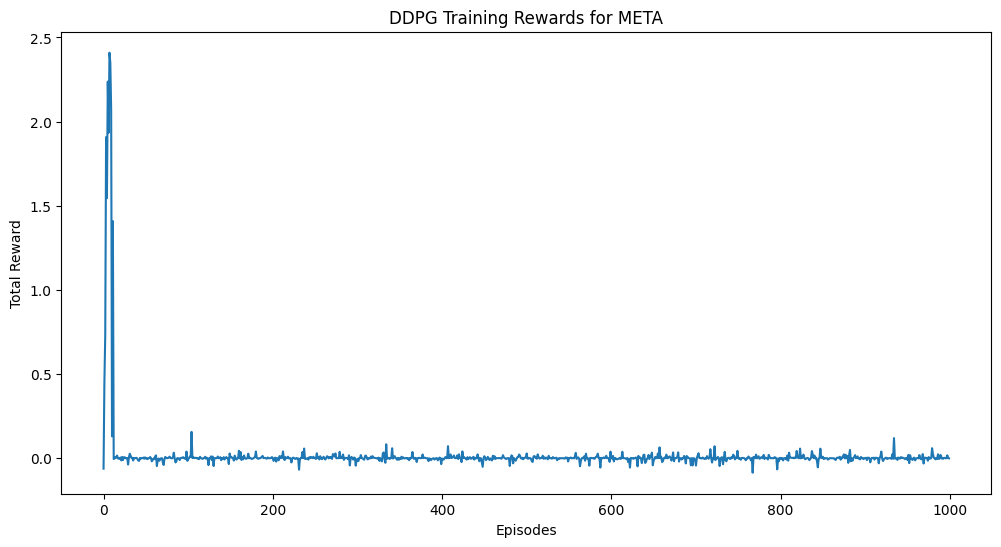


Testing DDPG agent for META
Test completed. Total Reward: 0.0


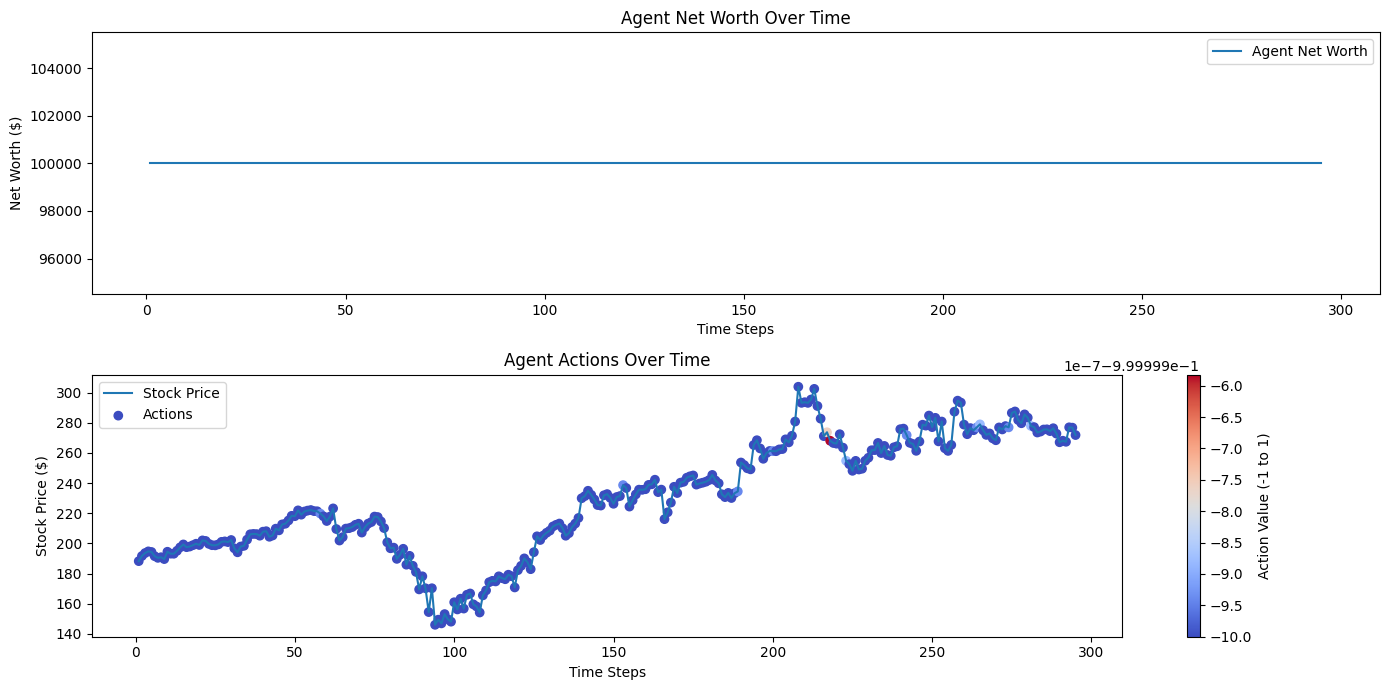

Total Return: 0.00%
Annualized Return: 0.00%
Sharpe Ratio: 0.00
Maximum Drawdown: 0.00%


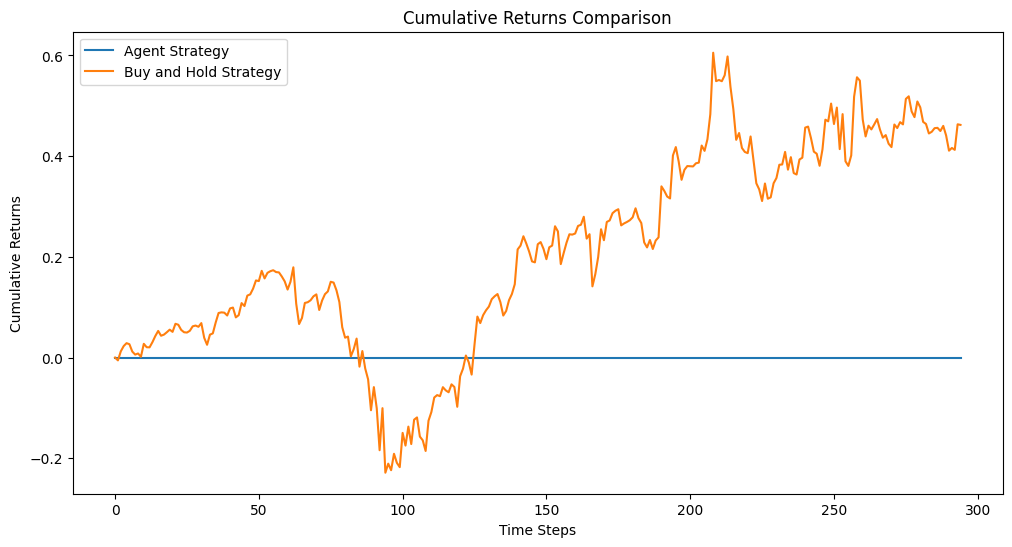

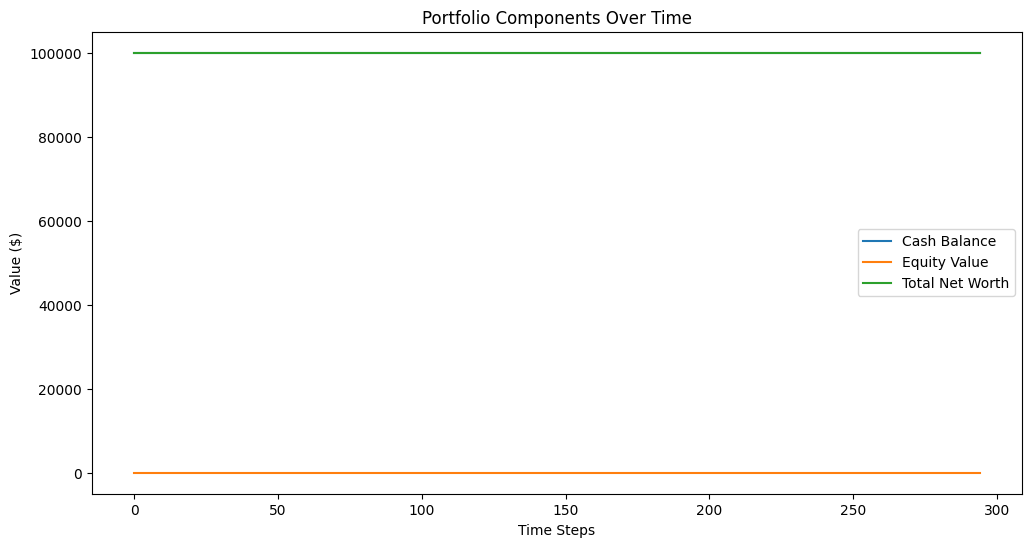


Training DDPG agent for NVDA
Episode 1/1000, Total Reward: 11.40
Episode 2/1000, Total Reward: 9.43
Episode 3/1000, Total Reward: 10.26
Episode 4/1000, Total Reward: 9.46
Episode 5/1000, Total Reward: 9.49
Episode 6/1000, Total Reward: 9.43
Episode 7/1000, Total Reward: 9.45
Episode 8/1000, Total Reward: 9.42
Episode 9/1000, Total Reward: 9.45
Episode 10/1000, Total Reward: 8.61
Episode 11/1000, Total Reward: 9.40
Episode 12/1000, Total Reward: 9.49
Episode 13/1000, Total Reward: 9.45
Episode 14/1000, Total Reward: 9.44
Episode 15/1000, Total Reward: 9.22
Episode 16/1000, Total Reward: 9.49
Episode 17/1000, Total Reward: 9.44
Episode 18/1000, Total Reward: 9.45
Episode 19/1000, Total Reward: 9.46
Episode 20/1000, Total Reward: 9.39
Episode 21/1000, Total Reward: 9.40
Episode 22/1000, Total Reward: 9.46
Episode 23/1000, Total Reward: 9.48
Episode 24/1000, Total Reward: 9.47
Episode 25/1000, Total Reward: 9.55
Episode 26/1000, Total Reward: 9.32
Episode 27/1000, Total Reward: 9.38
Episo

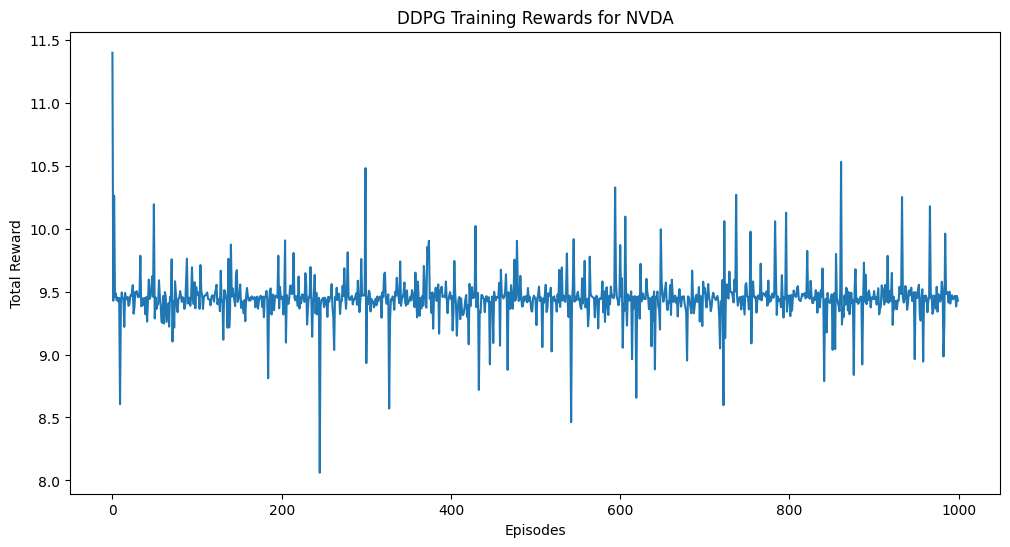


Testing DDPG agent for NVDA
Test completed. Total Reward: 2.065757428231516


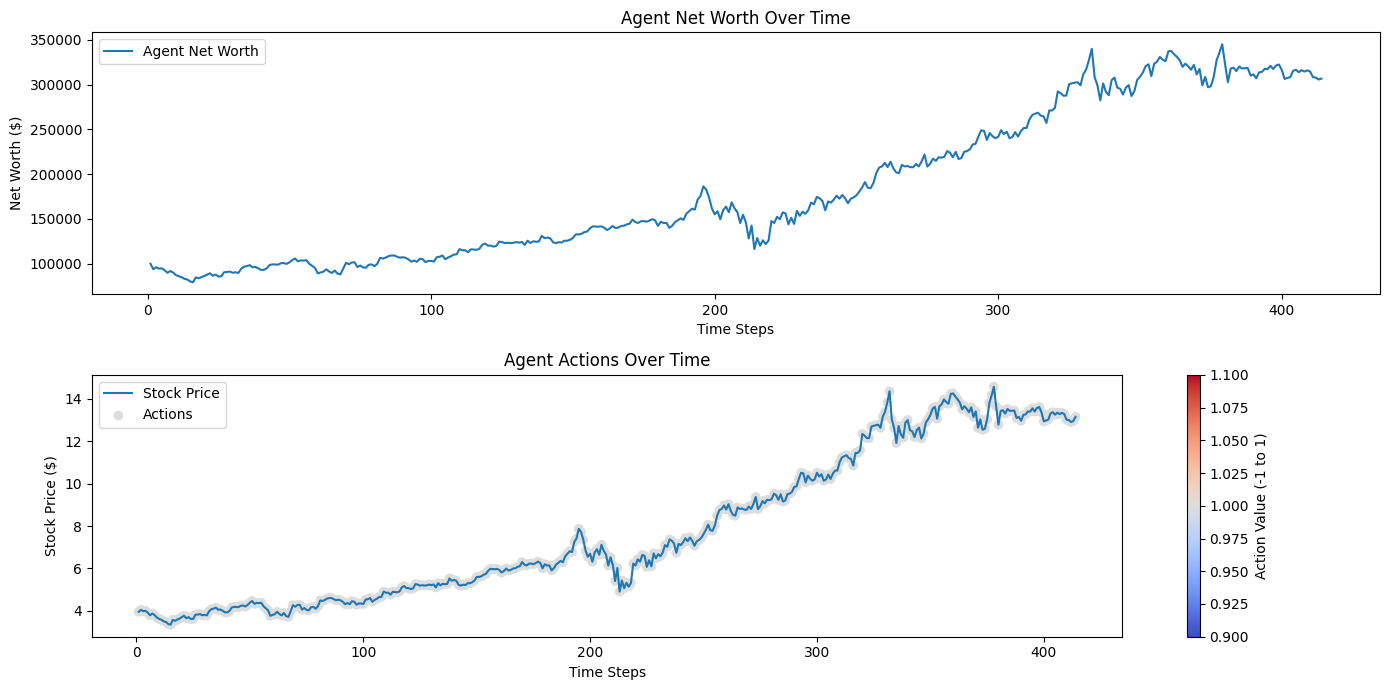

Total Return: 206.68%
Annualized Return: 125.80%
Sharpe Ratio: 1.60
Maximum Drawdown: 37.59%


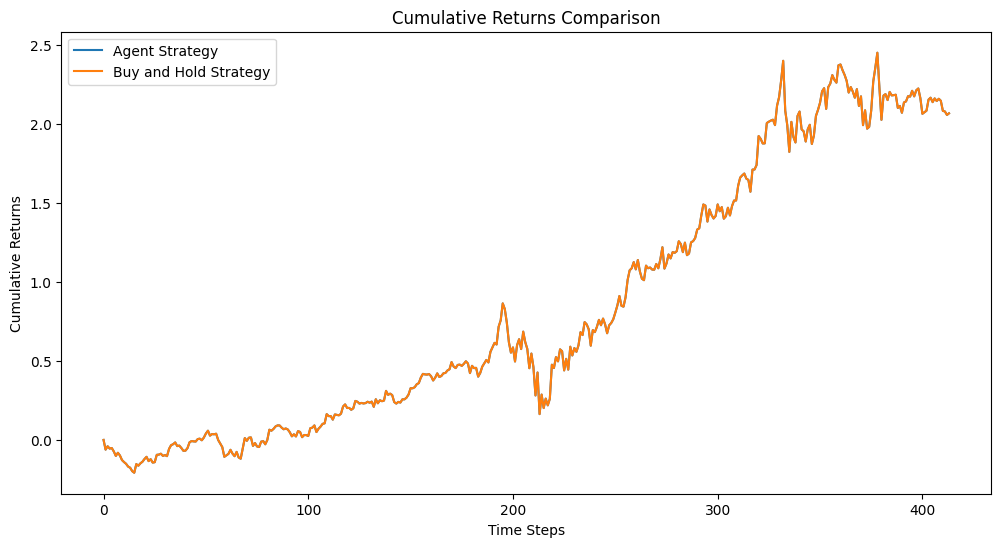

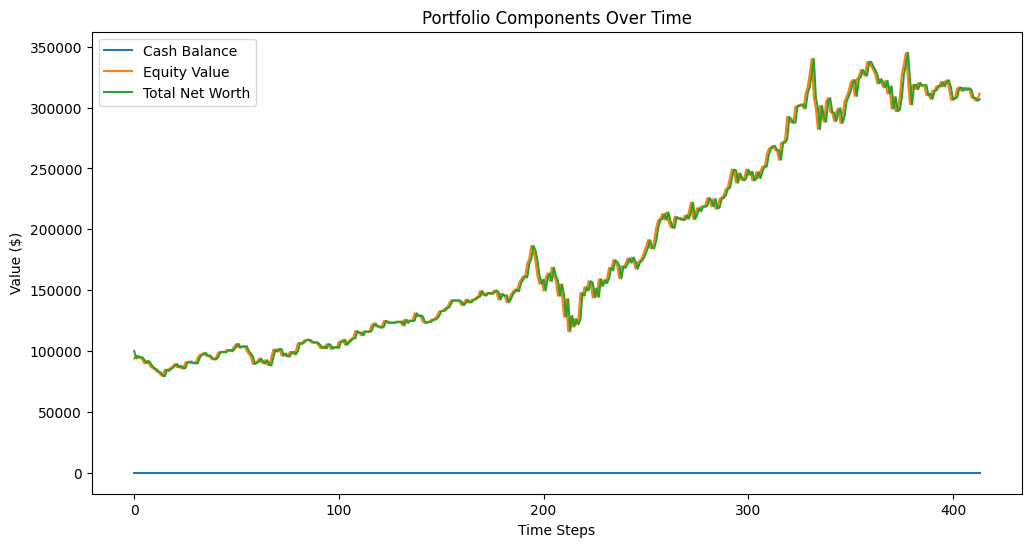

In [11]:
if __name__ == "__main__":
    # Prepare environment and data as before
    # ... [data preparation code] ...

    num_episodes = 1000
    batch_size = 64
    max_steps = 5000
    device = 'cuda'

    for ticker in STOCKS:
        print(f"\nTraining DDPG agent for {ticker}")
        # Prepare environment
        df_train = train_data[ticker]
        env = TradingEnv(df_train)
        # Determine state and action sizes
        state_size = env.observation_space.shape[0] * env.observation_space.shape[1]
        action_size = env.action_space.shape[0]
        # Initialize DDPG agent
        agent = DDPGAgent(state_size=state_size, action_size=action_size, device='cuda')
        # Train agent
        rewards_history = train_ddpg_agent(env, agent, num_episodes=num_episodes, batch_size=batch_size, max_steps=max_steps)
        # Save the trained model
        torch.save(agent.actor.state_dict(), f'ddpg_actor_{ticker}.pt')
        torch.save(agent.critic.state_dict(), f'ddpg_critic_{ticker}.pt')
        print(f"Trained DDPG agent for {ticker} saved.")
        # Plot training rewards
        plt.figure(figsize=(12,6))
        plt.plot(rewards_history)
        plt.xlabel('Episodes')
        plt.ylabel('Total Reward')
        plt.title(f'DDPG Training Rewards for {ticker}')
        plt.show()
        # Testing the agent on test data
        print(f"\nTesting DDPG agent for {ticker}")
        df_test = test_data[ticker]
        env_test = TradingEnv(df_test)
        agent.actor.eval()
        net_worths, actions, prices, steps, balances, shares_helds = test_ddpg_agent(env_test, agent)
        # Compute equity values
        equity_values = [shares_helds[i] * prices[i] for i in range(len(shares_helds))]
        # Plot test performance
        plot_test_performance_ddpg(net_worths, actions, prices, steps)
        compute_performance_metrics(net_worths)
        plot_cumulative_returns(net_worths, env_test)
        plot_portfolio_components(net_worths, balances, equity_values)
